In [1]:
from bjPOI import read_csv
from datetime import datetime
from datetime import date as dt
import numpy as np
import matplotlib.pyplot as plt
import math

MATCHING_DISTANCE = 0.1
MATCHING_TIME_FRAME = 3

def matchTime(t1, t2):
	return abs(datetime.fromtimestamp(t1).hour - datetime.fromtimestamp(t2).hour)<= MATCHING_TIME_FRAME # time difference no greater than 3 hours
	
def match(gps1, gps2):
    lat1, lon1, t1 = gps1
    lat2, lon2, t2 = gps2
    coord1 = (lat1,lon1)
    coord2 = (lat2,lon2)

    r = 6371
    dlat = (lat2-lat1) * (math.pi/180)
    dlon = (lon2-lon1) * (math.pi/180)

    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(lat1 * (math.pi/180)) * math.cos(lat2 * (math.pi/180)) * math.sin(dlon/2) * math.sin(dlon/2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = r * c

    return d <= MATCHING_DISTANCE and matchTime(t1, t2)

def trajectory_by_day(fname):
	trajectories = {}
	for i in range(1,8):
		trajectories[i] = []
	trajectory = read_csv(fname)
	print("Read CSV file")
	start = False
	last_date = dt.min
	last_day = 0
	for data_tup in trajectory:
		day = datetime.fromtimestamp(data_tup[2]).isoweekday()
		if day == last_day:
			date = dt.fromtimestamp(data_tup[2])
			if date == last_date:
				trajectories[day][-1].append(data_tup)
			else:
				one_trajectory = [data_tup]
				trajectories[day].append(one_trajectory)
				last_date = date
		else:
			date = dt.fromtimestamp(data_tup[2])
			one_trajectory = [data_tup]
			trajectories[day].append(one_trajectory)
			last_date = date
			last_day = day

	return trajectories

# gap -2, match +5, mismatch -3
def EDR(t1, t2, mt, ms, gap):
	m, n = len(t1), len(t2)
	matcher = [[0 for x in range(n+1)] for y in range(m+1)]
	backtrack = [[(-1,-1) for x in range(n+1)] for y in range(m+1)]
	maxscore = 0
	endposition = (0, 0)
	for i in range(1, m+1):
		for j in range(1, n+1):
			gapAbove = matcher[i-1][j]+gap
			gapLeft = matcher[i][j-1]+gap
			matching = matcher[i-1][j-1] + (mt if match(t1[i-1],t2[j-1]) else ms)
			score = max(0, max(gapAbove, gapLeft, matching)) # if negative, convert to 0
			matcher[i][j] = score

			# set backtrack table
			if score == matching:
				backtrack[i][j] = (i-1, j-1)
			elif score == gapAbove:
				backtrack[i][j] = (i-1, j)
			elif score == gapLeft:
				backtrack[i][j] = (i, j-1)
			else:
				backtrack[i][j] = (-1, -1)

			# update maxscore
			if score > maxscore:
				maxscore = score
				endposition = (i, j)

	tempi, tempj = endposition
	while backtrack[tempi][tempj] != (-1, -1):
		tempi, tempj = backtrack[tempi][tempj]

	# calculate time duration of both subtrajectories
	start1 = datetime.fromtimestamp(t1[tempi][2]).isoformat()
	end1 =datetime.fromtimestamp(t1[endposition[0]-1][2]).isoformat()
	start2 = datetime.fromtimestamp(t2[tempj][2]).isoformat()
	end2 =datetime.fromtimestamp(t2[endposition[1]-1][2]).isoformat()
	timeduration1 = t1[endposition[0]-1][2] - t1[tempi][2] # in seconds
	timeduration2 = t2[endposition[1]-1][2] - t2[tempj][2] # in seconds

	return (maxscore, start1, end1, timeduration1, start2, end2, timeduration2)

# only plot without writing to file
def EDR_all(traj_dict, day, mt, ms, gap):
    trajectories = traj_dict[day]
    duration_score_set = []
    duration_score_set.append([])
    duration_score_set.append([])
    for i in range(len(trajectories)-1):
        for j in range(i+1, len(trajectories)-1):
            score, start1, end1, duration1, start2, end2, duration2 = EDR(trajectories[i], trajectories[j], mt, ms, gap)
#             line = "Score: " + str(score) + " Duration 1: " + str(duration1) + "s (from " + str(start1) + " to " + str(end1) + ") Duration 2: " + str(duration2) + "s (from " + str(start2) + " to " + str(end2) + ")\n"
#             print(line)
            duration_score_set[0].append(min(duration1, duration2))
            duration_score_set[1].append(score)
    return duration_score_set

In [2]:
def scatter(data_set, title, plotout):
	data = np.asarray(data_set)
	x,y = data
	plt.scatter(x,y)
	plt.title(title)
	plt.xlabel('Duration')
	plt.ylabel('Score')
	plt.savefig(plotout)

In [3]:
traj_dict = trajectory_by_day("../Data/DataByPerson/000.csv")

Read CSV file


In [4]:
mt = 7
ms = -3
gap = -2

In [5]:
filein = "../Data/DataByPerson/000.csv"

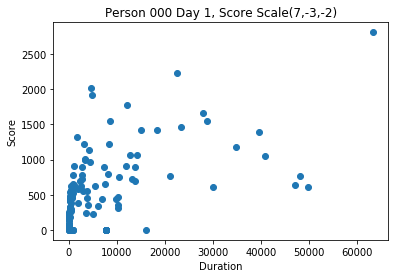

In [6]:
monday = EDR_all(traj_dict, 1, mt, ms, gap)
string1 = "Person " + str(filein[-7:-4]) + " Day 1, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(monday, string1, "../Result/Periodicity/000/distribution732_1.png")

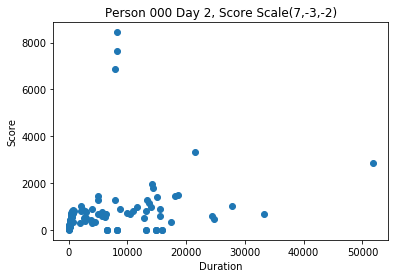

In [7]:
tuesday = EDR_all(traj_dict, 2, mt, ms, gap)
string2 = "Person " + str(filein[-7:-4]) + " Day 2, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(tuesday, string2, "../Result/Periodicity/000/distribution732_2.png")

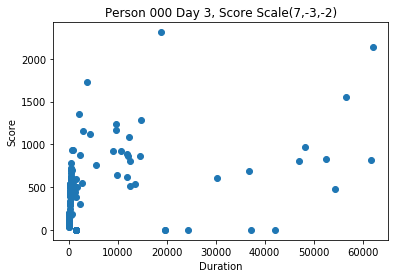

In [8]:
wednesday = EDR_all(traj_dict, 3, mt, ms, gap)
string3 = "Person " + str(filein[-7:-4]) + " Day 3, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(wednesday, string3, "../Result/Periodicity/000/distribution732_3.png")

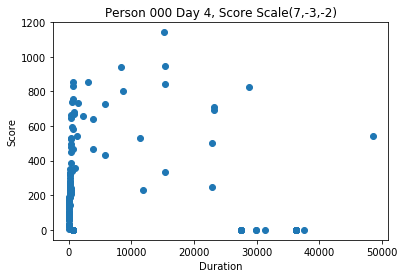

In [9]:
thursday = EDR_all(traj_dict, 4, mt, ms, gap)
string4 = "Person " + str(filein[-7:-4]) + " Day 4, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(thursday, string4, "../Result/Periodicity/000/distribution732_4.png")

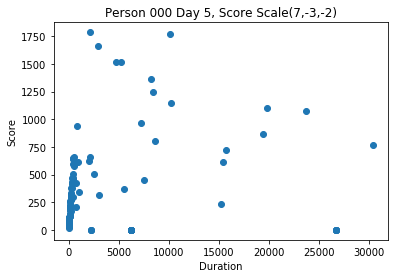

In [10]:
friday = EDR_all(traj_dict, 5, mt, ms, gap)
string5 = "Person " + str(filein[-7:-4]) + " Day 5, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(friday, string5, "../Result/Periodicity/000/distribution732_5.png")

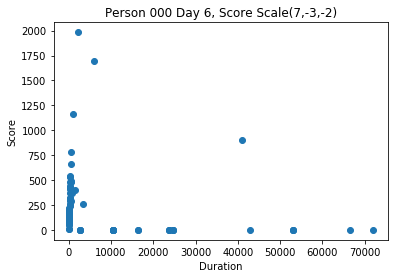

In [11]:
saturday = EDR_all(traj_dict, 6, mt, ms, gap)
string6 = "Person " + str(filein[-7:-4]) + " Day 6, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(saturday, string6, "../Result/Periodicity/000/distribution732_6.png")

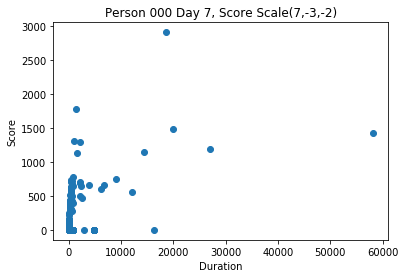

In [12]:
sunday = EDR_all(traj_dict, 7, mt, ms, gap)
string7 = "Person " + str(filein[-7:-4]) + " Day 7, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
scatter(sunday, string7, "../Result/Periodicity/000/distribution732_7.png")

In [9]:
def grapher(filein, mt, ms, gap):
    traj_dict = trajectory_by_day(filein)
    monday = EDR_all(traj_dict, 1, mt, ms, gap)
    string1 = "Person " + str(filein[-7:-4]) + " Day 1, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(monday, string1, "../Result/Periodicity/000/distribution532_1.png")
    tuesday = EDR_all(traj_dict, 2, mt, ms, gap)
    string2 = "Person " + str(filein[-7:-4]) + " Day 2, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(tuesday, string2, "../Result/Periodicity/000/distribution532_2.png")
    wednesday = EDR_all(traj_dict, 3, mt, ms, gap)
    string3 = "Person " + str(filein[-7:-4]) + " Day 3, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(wednesday, string3, "../Result/Periodicity/000/distribution532_3.png")
    thursday = EDR_all(traj_dict, 4, mt, ms, gap)
    string4 = "Person " + str(filein[-7:-4]) + " Day 4, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(thursday, string4, "../Result/Periodicity/000/distribution532_4.png")
    friday = EDR_all(traj_dict, 5, mt, ms, gap)
    string5 = "Person " + str(filein[-7:-4]) + " Day 5, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(friday, string5, "../Result/Periodicity/000/distribution532_5.png")
    saturday = EDR_all(traj_dict, 6, mt, ms, gap)
    string6 = "Person " + str(filein[-7:-4]) + " Day 6, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(saturday, string6, "../Result/Periodicity/000/distribution532_6.png")
    sunday = EDR_all(traj_dict, 7, mt, ms, gap)
    string7 = "Person " + str(filein[-7:-4]) + " Day 7, Score Scale(" + str(mt) + "," + str(ms) + "," + str(gap) + ")"
    scatter(sunday, string7, "../Result/Periodicity/000/distribution532_7.png")